In [73]:
import temgymbasic.jax_components as comp
from temgymbasic.jax_run import run_to_end
from temgymbasic.jax_ray import Ray
from temgymbasic.jax_source import ParallelBeam
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
%matplotlib widget

In [10]:
import sympy as sp

def calculate_object_plane(f, z2):
	return (1/f - 1/z2)**-1

def calculate_image_plane(f, z1):
	return (1/f + 1/z1)**-1

def calculate_focal_length(z1, z2):
	return (1/z1 + 1/z2)**-1

def calculate_image_plane_from_f_and_M(f, M):
	return f * (1 - M)

def calculate_object_plane_from_f_and_M(f, M):
	return f * (1/M - 1)

def propagation_matrix(d, xp=sp):
	if xp == sp:
		return xp.Matrix([[1, d, 0],
						  [0, 1, 0],
						  [0, 0, 1]])
	else:
		return xp.array([[1, d, 0],
						 [0, 1, 0],
						 [0, 0, 1]])

def thin_lens_matrix(f, xp=sp):
	if xp == sp:
		return xp.Matrix([[1, 0, 0],
						  [-1/f, 1, 0],
						  [0, 0, 1]])
	else:
		return xp.array([[1, 0, 0],
						 [-1/f, 1, 0],
						 [0, 0, 1]])

def imaging_matrix(M, f, xp=sp):
	if xp == sp:
		return xp.Matrix([[M, 0, 0],
						  [-1/f, 1/M, 0],
						  [0, 0, 1]])
	else:
		return xp.array([[M, 0, 0],
						 [-1/f, 1/M, 0],
						 [0, 0, 1]])
	
def scan_matrix(dx, xp=sp):
	if xp == sp:
		return xp.Matrix([[1, 0, dx],
						  [0, 1, 0],
						  [0, 0, 1]])
	else:
		return xp.array([[1, 0, dx],
						 [0, 1, 0],
						 [0, 0, 1]])
	
#4D Stem Ray Transfer Matrices
A, B, C, D, E, F, L = sp.symbols('A B C D E F L')
x_1, x_prime_1 = sp.symbols(r'x_1 x_1{\prime}')
x_2, x_prime_2 = sp.symbols(r'x_2 x_2{\prime}')
z_source = sp.symbols('z_source')
x_scan = sp.symbols('x_scan')
z_samp = sp.symbols('z_samp')
z_obj = sp.symbols('z_obj')
f_obj = sp.symbols('f_obj')
d_obj_proj = sp.symbols('d_obj-int')
z_int = sp.symbols('z_int')
f_int = sp.symbols('f_int')
z_proj = sp.symbols('z_proj')
z_det = sp.symbols('z_det')
M_proj = sp.symbols('M_proj')
f_proj = sp.symbols('f_proj')

scan_x = scan_matrix(x_scan, sp)
prop_sample_to_obj_lens = propagation_matrix(z_samp, sp)
obj_lens_f = thin_lens_matrix(f_obj, sp)
descan_x = scan_matrix(-x_scan, sp)
proj_lens_f = thin_lens_matrix(f_proj, sp)
prop_proj_lens_to_det = propagation_matrix(z_det - z_proj, sp)

matrices = [prop_proj_lens_to_det, proj_lens_f, obj_lens_f, prop_sample_to_obj_lens]
stem_matrix = sp.eye(3)
for matrix in reversed(matrices):
	stem_matrix = matrix @ stem_matrix

stem_matrix = stem_matrix.applyfunc(sp.simplify)
display(stem_matrix)

A_eq = sp.Eq(A, stem_matrix[0, 0]).simplify()
B_eq = sp.Eq(B, stem_matrix[0, 1]).simplify()
C_eq = sp.Eq(C, stem_matrix[1, 0]).simplify()
D_eq = sp.Eq(D, stem_matrix[1, 1]).simplify()
E_eq = sp.Eq(E, stem_matrix[0, 2]).simplify()
F_eq = sp.Eq(F, stem_matrix[1, 2]).simplify()

display(A_eq.simplify().expand())
display(B_eq.simplify())
display(C_eq.simplify())
display(D_eq.simplify())
display(E_eq.simplify())
display(F_eq.simplify())

x_2 = A_eq.rhs * 0.0 + B_eq.rhs * x_prime_1 + E_eq.rhs
display(x_2.simplify())

Matrix([
[(f_obj*f_proj - (f_obj + f_proj)*(z_det - z_proj))/(f_obj*f_proj), z_samp - (z_det - z_proj)*(-1 + z_samp/f_proj + z_samp/f_obj), 0],
[                                 (-f_obj - f_proj)/(f_obj*f_proj),                              1 - z_samp/f_proj - z_samp/f_obj, 0],
[                                                                0,                                                             0, 1]])

Eq(A, 1 - z_det/f_proj + z_proj/f_proj - z_det/f_obj + z_proj/f_obj)

Eq(B, z_samp - (z_det - z_proj)*(-1 + z_samp/f_proj + z_samp/f_obj))

Eq(C, (-f_obj - f_proj)/(f_obj*f_proj))

Eq(D, 1 - z_samp/f_proj - z_samp/f_obj)

Eq(E, 0)

Eq(F, 0)

x_1{\prime}*(f_obj*f_proj*z_samp - (z_det - z_proj)*(-f_obj*f_proj + f_obj*z_samp + f_proj*z_samp))/(f_obj*f_proj)

In [92]:
x_scan_val = 0.0
f_obj_val = 0.1
f_int_val = 0.1
M_proj_val = 10.0

z_samp_val = 0.05
z_obj_val = 0.1
z_proj_val = 0.1
z_det_val = 1.0

# zimg_proj_val = z_det_val - z_proj_val
# zobj_proj_val = zimg_proj_val / M_proj_val
# f_proj_val = calculate_focal_length(abs(zobj_proj_val), zimg_proj_val)
f_proj_val = -0.04

scan_x = scan_matrix(x_scan_val, np)
prop_crossover_to_sample = propagation_matrix(z_samp_val, np)
prop_sample_to_obj_lens = propagation_matrix(z_obj_val - z_samp_val, np)
obj_lens_f = thin_lens_matrix(f_obj_val, np)
descan_x = scan_matrix(-x_scan_val, np)
prop_obj_to_proj_lens = propagation_matrix(z_proj_val - z_obj_val, np)
proj_lens_f = thin_lens_matrix(f_proj_val, np)
prop_proj_lens_to_det = propagation_matrix(z_det_val - z_proj_val, np)

matrices_with_val = [prop_proj_lens_to_det, proj_lens_f, prop_obj_to_proj_lens, descan_x, obj_lens_f, prop_sample_to_obj_lens, prop_crossover_to_sample, scan_x]


Total ABCDEF matrix:
[[14.5   2.35  0.  ]
 [15.    2.5   0.  ]
 [ 0.    0.    1.  ]]


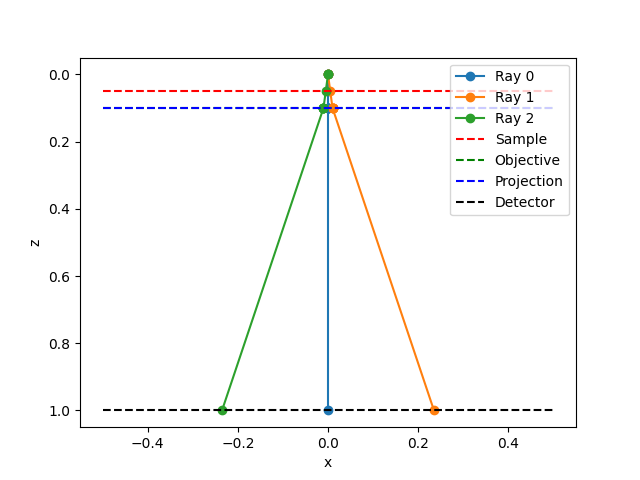

In [93]:
# Initialize the initial rays array and record the starting z position (assumed 0)

x0 = 0.0
initial_rays = np.array([[x0, 0, 1],
                         [x0, 0.1, 1],
                         [x0, -0.1, 1]])
all_rays = [initial_rays]
all_z = [0.0]

current_rays = initial_rays
current_z = 0.0

# Loop over matrices (using the numeric matrices with values)

# Compute the total ABCDEF matrix by multiplying from right to left.
total_matrix = np.eye(3)
for matrix in reversed(matrices_with_val):
    total_matrix = matrix @ total_matrix

print("Total ABCDEF matrix:")
print(total_matrix)


# Loop over matrices (using the numeric matrices with values)
for matrix in reversed(matrices_with_val):
    # Apply the transformation
    new_rays = current_rays @ matrix.T

    # Check if the matrix is a propagation matrix. For a propagation matrix in our setup
    # we expect its form to be: [[1, d, 0], [0, 1, 0], [0, 0, 1]].
    if (matrix[0, 0] == 1.0 and 
        matrix[1, 0] == 0.0 and 
        matrix[1, 1] == 1.0 and 
        matrix[0, 1] != 0.0):
        # Increment cumulative z by the propagation distance in the matrix.
        current_z += matrix[0,1]
    
    # Save the transformed rays and the associated z value.
    all_rays.append(new_rays)
    all_z.append(current_z)
    
    # Update rays to the new position for next iteration.
    current_rays = new_rays

plt.figure()
# Plot the ray trajectories: each ray is tracked separately along the z axis
num_rays = initial_rays.shape[0]
for i in range(num_rays):
    x_positions = [seg[i, 0] for seg in all_rays]
    plt.plot(x_positions, all_z, marker='o', label=f'Ray {i}')
plt.hlines(z_samp_val, xmin=-0.5, xmax=0.5, color='r', linestyle='--', label='Sample')
plt.hlines(z_obj_val, xmin=-0.5, xmax=0.5, color='g', linestyle='--', label='Objective')
plt.hlines(z_proj_val, xmin=-0.5, xmax=0.5, color='b', linestyle='--', label='Projection')
plt.hlines(z_det_val, xmin=-0.5, xmax=0.5, color='k', linestyle='--', label='Detector')

plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.gca().invert_yaxis()  # Flip the y-axis
plt.show()


In [63]:
@jdc.pytree_dataclass
class FourDSTEMModel:
    z: float # Z position of source
    UpperScanCoils: DoubleDeflector
    Sample: Sample
    ObjectiveLens: Lens
    LowerScanCoils: DoubleDeflector
    IntermediateLens: Lens
    ProjectorLens: Lens
    Detector: Detector


model = [comp.DoubleDeflector(z=0.1,
                              first=comp.Deflector(z=0.2, def_x=0.0, def_y=0.0), 
                              second=comp.Deflector(z=0.25, def_x=0.0, def_y=0.0)),
         comp.Sample(z=0.3),
         comp.Lens(z=0.35, focal_length=0.05), # objective lens
         comp.DoubleDeflector(z=0.4,
                              first=comp.Deflector(z=0.45, def_x=0.0, def_y=0.0), 
                              second=comp.Deflector(z=0.50, def_x=0.0, def_y=0.0)),
         comp.Lens(z=0.55, focal_length=0.05), # intermediate lens
         comp.Lens(z=0.6, focal_length=0.05), # projector lens
         comp.Detector(z=2.0, pixel_size=0.01, shape=(100, 100))]

NameError: name 'jdc' is not defined